### Things to do

- ?
    - Official adaptation rate method
    - Hemisphere
- Analyze blocked and shuffled data in NCM and Field L
    - Check if there is a difference between NCM and Field L
    - Determine if there is a loss of decoding accuracy accross stimulus repetition
    - Hemispheric differences?
    - Analyze single unit data in a similar fashion
    - Figure out why part of shuffled data appears to be corrupted
   
- Analyze contrast data
    - Compare decoding accuracy between first and second half of presentations

In [1]:
import mdlab as mdl
import dnlab as dnl
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as sst
import pandas as pd
import pdb

In [2]:
frcc=mdl.FRCC()
trailing_type = frcc.trailing_type
trailing_param = frcc.get_trailing_param(trailing_type)
stats_test = frcc.stats_test

In [4]:
mdl.get_pathname()

'/Users/david/Documents/blocked.npz'

In [3]:
header, spikes = mdl.load_npz_data('/Users/david/Documents/blocked.npz', False)
block = mdl.SpikeData(header, spikes)
#mua_block=block.mua_or_sua("mua")
sep_mua_block = dnl.separate_npz_data(block)

In [4]:
dnl.convert_electrodes(sep_mua_block, n=100)

/Users/david/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [5]:
res_block = dnl.res_filter(sep_mua_block)

In [18]:
res_block[0].electrodes

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1700, 1800, 1900, 2000, 2100, 2200, 2300,
       2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100])

In [6]:
def site_check(site_data, frcc=frcc):
    trailing_type = frcc.trailing_type
    trailing_param = frcc.get_trailing_param(trailing_type)
    p_values = []
    for stim in site_data.stim:
        stim_data = site_data.get_kw_SpikeData(stim = stim)
        #baseline = stim_data.firing_rates(trailing_type, trailing_param, fr_type = 0)
        #stimulus = stim_data.firing_rates(trailing_type, trailing_param, fr_type = 1)
        #statistics, p_value = sst.wilcoxon(baseline, stimulus)
        fr = stim_data.firing_rates(trailing_type, trailing_param, fr_type = 2)
        base = np.zeros(len(fr))
        statistics, p_value = sst.ttest_rel(fr, base)
        #print baseline.shape
        p_values.append(p_value)
    return np.asarray(p_values)

In [7]:
# loop through spike data
# loop through electrodes
# check if electrode is responding
# if responding, add header and spike
# combine at the end
def res_filter(split_data, p_value= 0.01):
    # to prevent enormous amount of warnings
    import warnings; warnings.simplefilter('ignore')
    res_split_data = []
    for spike_data in split_data:
        res_ele = []
        for ele in spike_data.electrodes:
            ele_spike_data = spike_data.get_kw_SpikeData(electrode=ele)
            respond = ele_spike_data.res_check()
            if respond["res"][0] < p_value:
                res_ele.append(ele)
        res_data = spike_data.get_kw_SpikeData(electrode = res_ele)
        res_split_data.append(res_data)
    return res_split_data

In [8]:
# loop through spike data
# loop through electrodes
# check if electrode is responding
# if responding, add header and spike
# combine at the end
def res_filter2(split_data, p_value= 0.05):
    # to prevent enormous amount of warnings
    import warnings; warnings.simplefilter('ignore')
    res_split_data = []
    for spike_data in split_data:
        res_ele = []
        for ele in spike_data.electrodes:
            ele_spike_data = spike_data.get_kw_SpikeData(electrode=ele)
            respond = ele_spike_data.site_stats()
            if len(respond[respond["p"] < 0.05]) != 0:
                res_ele.append(ele)
        res_data = spike_data.get_kw_SpikeData(electrode = res_ele)
        res_split_data.append(res_data)
    return res_split_data

In [9]:
# loop through spike data
# loop through electrodes
# check if electrode is responding
# if responding, add header and spike
# combine at the end
def res_filter(split_data, p_value= 0.05):
    # to prevent enormous amount of warnings
    import warnings; warnings.simplefilter('ignore')
    res_split_data = []
    for spike_data in split_data:
        res_ele = []
        for ele in spike_data.electrodes:
            ele_spike_data = spike_data.get_kw_SpikeData(electrode=ele)
            respond = site_check(ele_spike_data)
            r = respond < p_value
            if np.any(r) and not np.any(np.isnan((respond))):
                res_ele.append(ele)
        res_data = spike_data.get_kw_SpikeData(electrode = res_ele)
        res_split_data.append(res_data)
    return res_split_data

In [ ]:
n =0
for ele in sep_mua_block[n].electrodes:
    ele_data = sep_mua_block[n].get_kw_SpikeData(electrode = ele)
    print mdl.birdid2str(ele_data.birdid[0])
    print ele
    if ele in res_block[n].electrodes:
        print "Responding"
    else:
        print "Not Responding"
    mdl.raster_plot(ele_data.spikes)
    plt.show()

In [ ]:
# loop through spike data
# loop through electrodes
# check if electrode is responding
# if responding, add header and spike
# combine at the end
def res_filter(split_data, p_value= 0.05):
    #res_test = pd.DataFrame(columns=['birdid', 'electrode', 'Z'])
    res_header = pd.DataFrame()
    res_spikes = []
    res_split_data = []
    for spike_data in split_data:
        for ele in spike_data.electrodes:
            ele_spike_data = spike_data.get_kw_SpikeData(electrode=ele)
            respond = ele_spike_data.res_check()
            if respond["res"][0] < p_value:
                res_spikes.append(ele_spike_data.spikes)
                res_header = res_header.append(ele_spike_data.header)
        #return res_logidx
        res_spikes = np.vstack(res_spikes).tolist()
        #return res_header
        new_spike_data = mdl.SpikeData(res_header, np.asarray(res_spikes))
        res_split_data.append(new_spike_data)
    return res_split_data

In [49]:
# calculates average adaptation rates for each site from trials 5-25 in a SpikeData (or BinnedData)
def get_adaptation_rate(SpikeData):
    adaptation_rates={}
    ele_arr=np.unique(SpikeData.header.electrode)
    stim_arr = np.unique(SpikeData.stim)
    for i in ele_arr:
        ele_data=SpikeData.get_kw_SpikeData(electrode=i)
        ele_rates=[]
        for j in stim_arr:
            stim_data=ele_data.get_kw_SpikeData(stim=j)
            fr=stim_data.firing_rates(trailing_type, trailing_param, fr_type = 1)
            ar=mdl.adaptation_rate(fr, robust=True)
            ele_rates.append(ar)
        adaptation_rates[i]=np.mean(ele_rates)
    return adaptation_rates

In [14]:
# does the knn algorithm on an array of experiments
def batch_decoding_accuracy(split_data, n_neighbors=15, reps=250, training=.5):
    # Runs the decoding accuracy KNN algorithm on an array of spike data objects
    # split_data is the spike data array, bird_ele_class is a dataframe containing all responding electrodes and the 
    # region they are from.    
    # n neighbors is the amount of neighbors for the knn algorithm
    # reps is the amount of repitions of the algorithm to run
    # training is the training proportion
    
    c = ['birdid','electrode', 'hemisphere', 'average_adaptation_rate','average_decoding_accuracy','decoding_accuracy']
    final_df = pd.DataFrame(columns = c)
    #loops through split data
    n = 1
    for spike_data in split_data:
        ele_num_arr = spike_data.electrodes
        bird_tag = chr(int(str(spike_data.birdid[0])[0:2])) + chr(int(str(spike_data.birdid[0])[2:4]))
        bird_id = bird_tag + str(spike_data.birdid[0])[-5:-2]
        for x, ele_num in enumerate(ele_num_arr):
            ele_spike_data = spike_data.get_kw_SpikeData(electrode = ele_num)
            ele_binned_data = dnl.Spike_to_Binned(ele_spike_data)
            decoding_acc = dnl.decoding_accuracy(ele_binned_data, k=n_neighbors, rep_num=reps, training_prop=training)
            avg_decoding_acc = np.mean(decoding_acc)
            if ele_num < 1600:
                to_add = [bird_id, ele_num, "Left", dnl.get_adaptation_rate(ele_spike_data)[ele_num],avg_decoding_acc, decoding_acc]
                final_df = final_df.append(pd.DataFrame([to_add], columns=c)) 
            else:
                to_add = [bird_id, ele_num, "Right", dnl.get_adaptation_rate(ele_spike_data)[ele_num], avg_decoding_acc, decoding_acc]
                final_df = final_df.append(pd.DataFrame([to_add], columns=c))
        print str(n)+" Experiments Analyzed"
        n+=1
    return final_df.reset_index(drop=True)

In [23]:
np.unique(np.array(res_block[0].header.stim))

array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
def decoding_accuracy(electrode, k=15, rep_num=250, training_prop=.5, custom_stim_id=True):
    # Generates parameters for acc and trial_sage
    num_stim = electrode.stim.shape[0] 
    total_trials = electrode.header.shape[0]
    trials_per_stim = total_trials/num_stim
    acc = np.zeros((num_stim, trials_per_stim))
    
    #2D array #2D array, stim id x the trials per stimulus, increments up by one every time given trial used as target
    trial_usage = np.ones((num_stim, trials_per_stim))
    
    indices = range(0, total_trials)
    stim_ids = np.array(electrode.header.stim)
    
    custom_stim_dict = {}
    
    if custom_stim_id:
        t=1
        for stim in electrode.stim:
            custom_stim_dict[stim] = t
            t+=1

    # Creates list of dicts of trial num to stimulus trial sxnum 
    stim_to_trial = []
    for stim_num in electrode.stim:
            stim_dict = {}
            stim_data = electrode.get_kw_BinnedData(keyword='stim', num=stim_num)
            for trial_num in range (0,trials_per_stim):
                try:
                    overall_trial_num = stim_data.header.iloc[[trial_num]].trial.max()
                except:
                    continue
                stim_dict[overall_trial_num] = trial_num
            stim_to_trial.append(stim_dict)

    # knn algorithm
    for i in range(0,rep_num):
        try:
            #split data in half
            training_bins, target_bins, training_idx, target_idx, training_stim_ids, target_stim_ids = split(electrode.bins, indices, stim_ids, train_size=training_prop, test_size=1-training_prop)
            model = knn(n_neighbors=k, metric='euclidean')
            model.fit(training_bins, training_stim_ids)
            pred = model.predict(target_bins)
        except:
            continue

        #Updates acc and trial usage
        for j in range(0, pred.shape[0]):
            stim_id= target_stim_ids[j]
            trial_num = target_idx[j]+1
            if custom_stim_id:
                try:
                    mod_stim_id = custom_stim_dict[stim_id]
                    true_trial_num = stim_to_trial[mod_stim_id-1][trial_num]
                    trial_usage[mod_stim_id-1][true_trial_num]+=1
                except:
                    continue
            elif not custom_stim_id:
                true_trial_num = stim_to_trial[stim_id-1][trial_num]
                trial_usage[stim_id-1][true_trial_num]+=1
            if pred[j] == stim_id and custom_stim_id:
                acc[mod_stim_id-1][true_trial_num] += 1
            if pred[j] == stim_id and not custom_stim_id:  
                acc[stim_id-1][true_trial_num] += 1
            
    final_acc = np.divide(acc, trial_usage)
    return final_acc  

In [15]:
block_df = batch_decoding_accuracy(res_block)

1 Experiments Analyzed
2 Experiments Analyzed
3 Experiments Analyzed
4 Experiments Analyzed
5 Experiments Analyzed
6 Experiments Analyzed
7 Experiments Analyzed
8 Experiments Analyzed


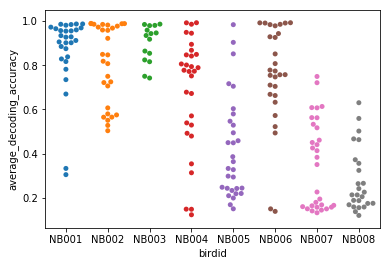